# Crypto coins Prediction 

# Import Libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go

import datetime
from pmdarima.arima import auto_arima # biblioteca que importa o arima
import pmdarima.arima as pm # biblioteca que importa o arima
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pandas as pd

from pandas_datareader import data 
import yfinance as yfin
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [2]:
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, MaxPooling1D, Activation, AveragePooling1D, BatchNormalization, Flatten, Dropout, SpatialDropout1D, GRU, GlobalAveragePooling1D
from tensorflow.keras import Input

## Exploratory Data Analysis (EDA)

### Loading data

In [3]:
yfin.pdr_override()

cryptos=['BTC','ETH','SOL','ADA','TRX','FET','INJ']
peso_cryptos=np.ones(len(cryptos))*1/len(cryptos)
# adc o .SA no nome de cada ação para carregar no banco de dados
for i in range(np.size(cryptos)):
    cryptos[i]=cryptos[i]+"-USD"

#cryptos.append('-USDT') # inclui o índice ibovespa na ultima coluna

cryptos_df = pd.DataFrame() 
for acao in cryptos:
     cryptos_df[acao] = data.DataReader(acao, start='2017-01-01')['Close']

# substitui o .SA do nome de cada ação para visualização dos dados
for i in range(np.size(cryptos)):
    cryptos_df = cryptos_df.rename(columns={cryptos[i]:cryptos[i].replace('-USDT', '')})

#renomeia o índice IBOVESPA para IBOV   
#cryptos_df = cryptos_df.rename(columns={cryptos[i]:cryptos[i].replace('^BVSP', 'IBOV')})
                           
#soma todos os valores nulos
cryptos_df.isnull().sum()

#Verifica como está o shape do dataframe
cryptos_df.shape
 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(2898, 7)

<Axes: ylabel='Date'>

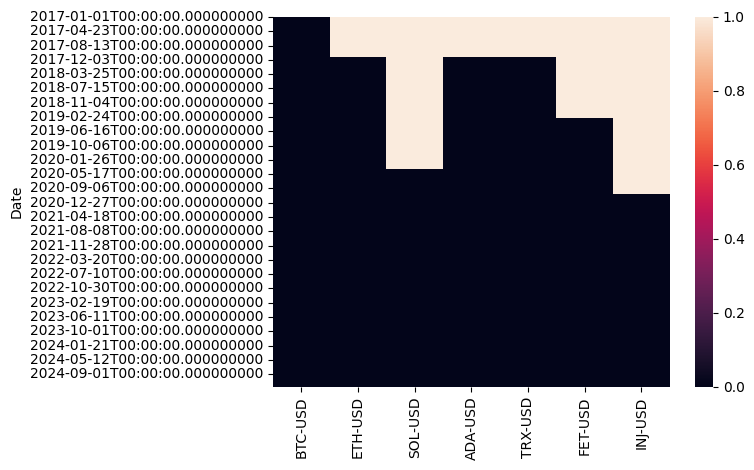

In [4]:
sns.heatmap(cryptos_df.isnull())

In [5]:
#apaga registros nulos
cryptos_df.dropna(inplace=True)
cryptos_df.to_csv('cryptos.csv')
cryptos_df

BTC-USD      ETH-USD     SOL-USD   ADA-USD   TRX-USD  \
Date                                                                    
2020-10-21  12823.689453   392.189972    1.890378  0.106187  0.026721   
2020-10-22  12965.891602   413.772980    1.955653  0.110572  0.027042   
2020-10-23  12931.539062   409.766693    1.960035  0.108083  0.026691   
2020-10-24  13108.062500   412.457611    1.911828  0.108075  0.027050   
2020-10-25  13031.173828   406.217773    1.787459  0.106351  0.026935   
...                  ...          ...         ...       ...       ...   
2024-12-03  96002.164062  3620.711670  234.200317  1.198126  0.425992   
2024-12-04  98768.531250  3841.331055  229.119293  1.187320  0.332399   
2024-12-05  96593.570312  3811.008301  233.998703  1.184712  0.319240   
2024-12-06  99920.710938  4005.810547  237.051071  1.231107  0.325985   
2024-12-07  99769.742188  4001.429932  240.901291  1.224239  0.322069   

             FET-USD    INJ-USD  
Date                             
2020-10-21  0.045765   0.773266  
2020-10-22  0.049113   0.789443  
2020-10-23  0.053041   1.183961  
2020-10-24  0.056407   0.965414  
2020-10-25  0.051211   0.901291  
...              ...        ...  
2024-12-03  1.919583  33.444778  
2024-12-04  1.865785  31.884499  
2024-12-05  1.937552  32.189957  
2024-12-06  2.131475  34.084061  
2024-12-07  2.108886  33.532784  

[1509 rows x 7 columns]

### Visualização dos dados 

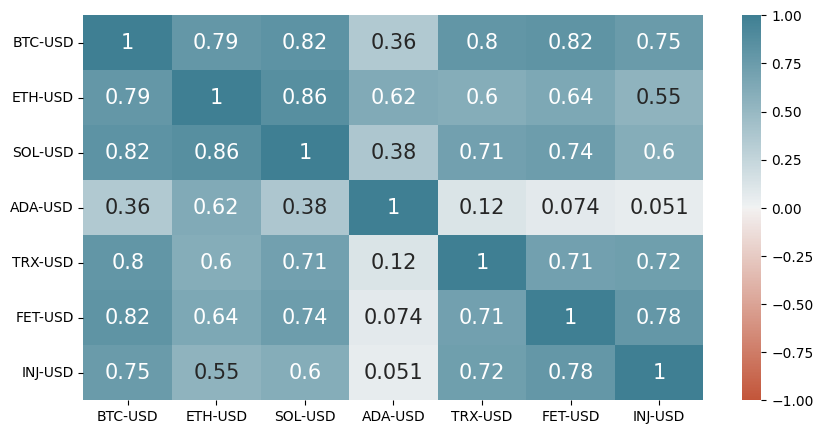

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))

columns=cryptos_df.columns
corrmat = cryptos_df[columns].corr()
mask= np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrmat,
            vmax=1, vmin=-1,
            annot=True, annot_kws={'fontsize':15},
            cmap=sns.diverging_palette(20,220,as_cmap=True))
plt.show()

In [7]:
# Normaliza os dados
cryptos_df_normalized = cryptos_df / cryptos_df.iloc[0].values

In [8]:
cryptos_df_normalized

BTC-USD    ETH-USD     SOL-USD    ADA-USD    TRX-USD    FET-USD  \
Date                                                                           
2020-10-21  1.000000   1.000000    1.000000   1.000000   1.000000   1.000000   
2020-10-22  1.011089   1.055032    1.034530   1.041295   1.012013   1.073156   
2020-10-23  1.008410   1.044817    1.036848   1.017855   0.998877   1.158986   
2020-10-24  1.022176   1.051678    1.011347   1.017780   1.012312   1.232536   
2020-10-25  1.016180   1.035768    0.945556   1.001544   1.008009   1.118999   
...              ...        ...         ...        ...        ...        ...   
2024-12-03  7.486314   9.232035  123.890734  11.283170  15.942218  41.944344   
2024-12-04  7.702037   9.794567  121.202899  11.181406  12.439617  40.768818   
2024-12-05  7.532432   9.717251  123.784081  11.156846  11.947158  42.336981   
2024-12-06  7.791885  10.213955  125.398768  11.593764  12.199581  46.574345   
2024-12-07  7.780112  10.202785  127.435513  11.529081  12.053019  46.080754   

              INJ-USD  
Date                   
2020-10-21   1.000000  
2020-10-22   1.020920  
2020-10-23   1.531117  
2020-10-24   1.248489  
2020-10-25   1.165564  
...               ...  
2024-12-03  43.251323  
2024-12-04  41.233544  
2024-12-05  41.628568  
2024-12-06  44.078053  
2024-12-07  43.365133  

[1509 rows x 7 columns]

In [9]:
#%% Carregando dados
cryptos_df=pd.read_csv('cryptos.csv')
cryptos_df['Date']=pd.to_datetime(cryptos_df['Date'])
cryptos_df=cryptos_df.set_index('Date')
for col in cryptos_df.columns:
    cryptos_df[col]=cryptos_df[col].astype('float32')

In [10]:
cryptos_df_normalized = cryptos_df / cryptos_df.iloc[0].values
#cryptos_df_normalized = cryptos_df / cryptos_df.iloc[-1].values

In [11]:
cryptos_df_normalized

BTC-USD    ETH-USD     SOL-USD    ADA-USD    TRX-USD    FET-USD  \
Date                                                                           
2020-10-21  1.000000   1.000000    1.000000   1.000000   1.000000   1.000000   
2020-10-22  1.011089   1.055032    1.034530   1.041295   1.012013   1.073156   
2020-10-23  1.008410   1.044817    1.036848   1.017855   0.998877   1.158986   
2020-10-24  1.022176   1.051678    1.011347   1.017780   1.012312   1.232536   
2020-10-25  1.016180   1.035768    0.945556   1.001544   1.008009   1.118999   
...              ...        ...         ...        ...        ...        ...   
2024-12-03  7.486314   9.232036  123.890732  11.283170  15.942218  41.944344   
2024-12-04  7.702037   9.794567  121.202896  11.181406  12.439617  40.768818   
2024-12-05  7.532432   9.717251  123.784081  11.156846  11.947158  42.336979   
2024-12-06  7.791885  10.213955  125.398766  11.593763  12.199581  46.574345   
2024-12-07  7.780112  10.202785  127.435516  11.529080  12.053019  46.080753   

              INJ-USD  
Date                   
2020-10-21   1.000000  
2020-10-22   1.020920  
2020-10-23   1.531117  
2020-10-24   1.248489  
2020-10-25   1.165564  
...               ...  
2024-12-03  43.251324  
2024-12-04  41.233543  
2024-12-05  41.628567  
2024-12-06  44.078053  
2024-12-07  43.365131  

[1509 rows x 7 columns]

In [12]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
for cryptos in cryptos_df.columns:
#fig.add_trace(go.Scatter(x=cryptos_df.index, y=cryptos_df['IBOV'], mode='lines', name='Preço do Ibovespa'))
#fig.add_trace(go.Scatter(x=cryptos_df.index, y=cryptos_df['B3SA3'], mode='lines', name='Preço do B3SA3'))
    fig.add_trace(go.Scatter(x=cryptos_df_normalized.index, y=cryptos_df_normalized[cryptos], mode='lines', name=f'Preço do {cryptos}'))

# Configura o layout do gráfico
fig.update_layout(
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)

# Exibe o gráfico
fig.show()

## Indicadores de tendência e Séries Temporais 

Os swing traders geralmente utilizam médias móveis exponenciais (EMAs) de diferentes períodos para identificar tendências e sinais de compra e venda. As EMAs mais utilizadas pelos swing traders incluem:

-EMA de 9 períodos: A EMA de 9 períodos é comumente usada para identificar sinais de curto prazo e capturar movimentos rápidos do mercado. Pode fornecer sinais mais sensíveis e frequentes.

-EMA de 20 períodos: A EMA de 20 períodos é amplamente utilizada e considerada uma média móvel de curto prazo. É usada para identificar a direção da tendência de curto prazo e possíveis pontos de reversão.

-EMA de 50 períodos: A EMA de 50 períodos é frequentemente usada para identificar a direção da tendência de médio prazo. É uma média móvel amplamente observada pelos swing traders.

-EMA de 100 períodos: A EMA de 100 períodos é usada para identificar a direção da tendência de médio a longo prazo. É útil para identificar pontos de entrada e saída em operações de swing trading mais prolongadas.

-EMA de 200 períodos: A EMA de 200 períodos é uma das médias móveis mais amplamente observadas e é usada para identificar a direção da tendência de longo prazo. É frequentemente usada como um indicador-chave para determinar a tendência geral do mercado.

In [13]:
import pandas as pd
import pandas_datareader as pdr
import datetime
import plotly.graph_objects as go

# Define o código de ticker da crypto
ticker = "BTC"


ticker=ticker+"-USD"

# Obtém os dados históricos da crypto
df = data.DataReader(ticker, start='2017-01-01')



[*********************100%%**********************]  1 of 1 completed


In [14]:
scaler = MinMaxScaler()
y=scaler.fit_transform(df['Close'].values.reshape(-1,1))

# Function to compute Simple Moving Average (SMA)
def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# Function to compute Relative Strength Index (RSI)
def calculate_rsi(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to compute Moving Average Convergence Divergence (MACD)
def calculate_macd(data, short_window, long_window, signal_window):
    short_ema = data['Close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    return macd_line, signal_line

def calculate_bollinger_bands(data, window=20, num_std=2):
    sma = data['Close'].rolling(window=window).mean()
    std = data['Close'].rolling(window=window).std()
    upper_band = sma + num_std * std
    lower_band = sma - num_std * std
    return upper_band, lower_band

df['upper_band_bollinger'],df['lower_band_bollinger']=calculate_bollinger_bands(df)
# Calcula as EMAs de 9 e 20 períodos
df['EMA9'] = df['Close'].ewm(span=9).mean()
df['EMA20'] = df['Close'].ewm(span=20).mean()
df['EMA50'] = df['Close'].ewm(span=50).mean()
df['EMA100'] = df['Close'].ewm(span=100).mean()
df['EMA200'] = df['Close'].ewm(span=200).mean()
df['MA111*2'] = df['Close'].rolling(window=111).mean() * 2
df['MA350*2'] = df['Close'].rolling(window=350).mean() * 2


# Calculate RSI (14-period)
df['RSI_14'] = calculate_rsi(df, window=14)

# Calculate MACD (12, 26, 9)
df['MACD'], df['Signal'] = calculate_macd(df, short_window=12, long_window=26, signal_window=9)


In [15]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['EMA9'], mode='lines', name='EMA9'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA20'], mode='lines', name='EMA20'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA50'], mode='lines', name='EMA50'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA100'], mode='lines', name='EMA100'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA200'], mode='lines', name='EMA200'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA111*2'], mode='lines', name='MA111*2'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA350*2'], mode='lines', name='MA350*2'))

if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [16]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['upper_band_bollinger'], mode='lines', name='upper band bollinger'))
fig.add_trace(go.Scatter(x=df.index, y=df['lower_band_bollinger'], mode='lines', name='lower band bollinger'))


if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [17]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'upper_band_bollinger', 'lower_band_bollinger', 'EMA9', 'EMA20',
       'EMA50', 'EMA100', 'EMA200', 'MA111*2', 'MA350*2', 'RSI_14', 'MACD',
       'Signal'],
      dtype='object')

In [18]:
df.index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2024-11-28', '2024-11-29', '2024-11-30', '2024-12-01',
               '2024-12-02', '2024-12-03', '2024-12-04', '2024-12-05',
               '2024-12-06', '2024-12-07'],
              dtype='datetime64[ns]', name='Date', length=2898, freq=None)

In [19]:

# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
df['Variation'] = ((df['Close'] - df['Close'].shift(+1)) / df['Close'])*100
#pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100


# Thresholds for variation classification
positive_threshold = 0.03
negative_threshold = -0.03

# Create a new column for classified variation
df['Classification'] = df['Variation'].apply(lambda x: 
                                            1 if x > positive_threshold else (
                                                -1 if x < negative_threshold else 0))

#df['week']=df.index.week
df['weekday']=df.index.weekday+1
df['day']=df.index.day
df['month']=df.index.month
df['quarter']=df.index.quarter

df=df.reset_index().fillna(0)
df


Date          Open           High           Low         Close  \
0    2017-01-01    963.658020    1003.080017    958.698975    998.325012   
1    2017-01-02    998.617004    1031.390015    996.702026   1021.750000   
2    2017-01-03   1021.599976    1044.079956   1021.599976   1043.839966   
3    2017-01-04   1044.400024    1159.420044   1044.400024   1154.729980   
4    2017-01-05   1156.729980    1191.099976    910.416992   1013.380005   
...         ...           ...            ...           ...           ...   
2893 2024-12-03  95854.593750   96297.203125  93629.562500  96002.164062   
2894 2024-12-04  95988.531250   99207.328125  94660.523438  98768.531250   
2895 2024-12-05  98741.539062  103900.468750  91998.781250  96593.570312   
2896 2024-12-06  97074.226562  102039.882812  96514.875000  99920.710938   
2897 2024-12-07  99869.976562  100500.242188  99175.171875  99680.414062   

         Adj Close        Volume  upper_band_bollinger  lower_band_bollinger  \
0       998.325012     147775008              0.000000              0.000000   
1      1021.750000     222184992              0.000000              0.000000   
2      1043.839966     185168000              0.000000              0.000000   
3      1154.729980     344945984              0.000000              0.000000   
4      1013.380005     510199008              0.000000              0.000000   
...            ...           ...                   ...                   ...   
2893  96002.164062   67067810961         101214.442380          87685.620901   
2894  98768.531250   77199817112         101139.403950          88912.469488   
2895  96593.570312  149218945580         101156.283867          89448.345820   
2896  99920.710938   94534772658         101523.604861          90017.248264   
2897  99680.414062   63590838272         101545.136697          90979.172678   

              EMA9  ...        MA350*2     RSI_14         MACD       Signal  \
0       998.325012  ...       0.000000   0.000000     0.000000     0.000000   
1      1011.338894  ...       0.000000   0.000000     1.868660     0.373732   
2      1024.659006  ...       0.000000   0.000000     5.073577     1.313701   
3      1068.720989  ...       0.000000   0.000000    16.372661     4.325493   
4      1052.258297  ...       0.000000   0.000000    13.762854     6.212965   
...            ...  ...            ...        ...          ...          ...   
2893  95841.963414  ...  125164.529665  57.740898  4440.582320  5252.970396   
2894  96427.276981  ...  125479.479844  59.075589  4391.506266  5080.677570   
2895  96460.535647  ...  125780.762232  45.736037  4129.509554  4890.443967   
2896  97152.570705  ...  126100.321138  51.828195  4142.594463  4740.874066   
2897  97658.139377  ...  126419.983259  53.921611  4086.468138  4609.992880   

      Variation  Classification  weekday  day  month  quarter  
0      0.000000               0        7    1      1        1  
1      2.292634               1        1    2      1        1  
2      2.116222               1        2    3      1        1  
3      9.603112               1        3    4      1        1  
4    -13.948368              -1        4    5      1        1  
...         ...             ...      ...  ...    ...      ...  
2893   0.142559               1        2    3     12        4  
2894   2.800859               1        3    4     12        4  
2895  -2.251662              -1        4    5     12        4  
2896   3.329781               1        5    6     12        4  
2897  -0.241067              -1        6    7     12        4  

[2898 rows x 25 columns]

## Data preprocessing to stock forecast

### Pré-processamento dos dados para predição 

In [20]:
ticker

'BTC-USD'

In [21]:
# Pré-processamento dos dados
cryptos_df.reset_index(inplace=True)
#ticker='IBOV'
if 'SA' in ticker:
    ticker=ticker[:-3]
    
cryptos_df = cryptos_df[['Date', ticker]]
cryptos_df.columns = ['ds', 'y']

In [22]:
# scale the data - normalization
cryptos_df_norm=cryptos_df.copy()
scaler = MinMaxScaler()
cryptos_df_norm['y'] = scaler.fit_transform(cryptos_df['y'].values.reshape(-1,1))

In [23]:
features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200',
                     'RSI_14', 'MACD','upper_band_bollinger', 'lower_band_bollinger']
cryptos_df = df[['Close']+features_indicators]  
cryptos_df_normalized = cryptos_df / cryptos_df.max().values
cryptos_df_normalized.describe()
cryptos_df['ds']=df['Date']

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_27488\2694008452.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
[feature.split('_') for feature in features_indicators]

[['EMA9'],
 ['EMA20'],
 ['EMA50'],
 ['EMA100'],
 ['EMA200'],
 ['RSI', '14'],
 ['MACD'],
 ['upper', 'band', 'bollinger'],
 ['lower', 'band', 'bollinger']]

In [25]:
def comput_features(data_array, lookback = 1, features_indicators=[]):
    """_summary_

    Args:
        data_array (_type_): transformed dat in scaler 
        lookback (int, optional): _description_. Defaults to 1.
        features_indicators (list, optional): _description_. Defaults to [].

    Returns:
        _type_: _description_
    """
    #df_=pd.DataFrame(data=scaler.inverse_transform(data_array.reshape(-1,1)),columns=['Close'])
    df_=pd.DataFrame(data=data_array.reshape(-1,1),columns=['Close'])


    if  True in ['bollinger' in feature.split('_') for feature in features_indicators]:
        df_['upper_band_bollinger'],df_['lower_band_bollinger']=calculate_bollinger_bands(df_)
    # Calcula as EMAs de 9 e 20 períodos
    if 'EMA9' in features_indicators:
        df_['EMA9'] = df_['Close'].ewm(span=9).mean()
    if 'EMA20' in features_indicators:   
        df_['EMA20'] = df_['Close'].ewm(span=20).mean()
    if 'EMA50' in features_indicators: 
        df_['EMA50'] = df_['Close'].ewm(span=50).mean()
    if 'EMA100' in features_indicators: 
        df_['EMA100'] = df_['Close'].ewm(span=100).mean()
    if 'EMA200' in features_indicators: 
        df_['EMA200'] = df_['Close'].ewm(span=200).mean()
    if 'MA111' in features_indicators: 
        df_['MA111'] = df_['Close'].rolling(window=111).mean()
    if 'MA350' in features_indicators: 
        df_['MA350'] = df_['Close'].rolling(window=350).mean() 
    if 'RSI_14' in features_indicators: 
        # Calculate RSI (14-period)
        df_['RSI_14'] = calculate_rsi(df, window=14)
    if 'MACD' in features_indicators: 
        # Calculate MACD (12, 26, 9)
        df_['MACD'], df_['Signal'] = calculate_macd(df_, short_window=12, long_window=26, signal_window=9)
    
    df_.iloc[:]= np.nan_to_num(df_.values)
    
    #return  df_[['Close']+features_indicators].iloc[-lookback:,:].values.reshape(1,-1)
    X_features=np.concatenate([df_['Close'].values[-lookback:],df_[features_indicators].values[-1]]).reshape(1, -1)

    #for columns in df_.columns:
    #    df_[columns]= scaler.transform(df_[columns].values.reshape(-1,1))
    #X_features=scaler.transformnp(concatenate([df_['Close'].values[-lookback:],df_[features_indicators].values[-1]]).reshape(1, -1))
    return X_features

features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200',
                     'MA111', 'MA350',
                     'RSI_14', 'MACD','upper_band_bollinger', 'lower_band_bollinger']

features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200', 
                     'MA111', 'MA350',
                     'MACD','upper_band_bollinger', 'lower_band_bollinger']
#df.loc[:,['Close']+features_indicators]=df_.loc[:,['Close']+features_indicators]
#features_indicators=[]

In [26]:
df_norm=df.copy()
df_norm['Close']=scaler.transform(df['Close'].values.reshape(-1,1))

In [27]:
df_norm

Date          Open           High           Low     Close  \
0    2017-01-01    963.658020    1003.080017    958.698975 -0.135772   
1    2017-01-02    998.617004    1031.390015    996.702026 -0.135503   
2    2017-01-03   1021.599976    1044.079956   1021.599976 -0.135250   
3    2017-01-04   1044.400024    1159.420044   1044.400024 -0.133977   
4    2017-01-05   1156.729980    1191.099976    910.416992 -0.135599   
...         ...           ...            ...           ...       ...   
2893 2024-12-03  95854.593750   96297.203125  93629.562500  0.955009   
2894 2024-12-04  95988.531250   99207.328125  94660.523438  0.986771   
2895 2024-12-05  98741.539062  103900.468750  91998.781250  0.961800   
2896 2024-12-06  97074.226562  102039.882812  96514.875000  1.000000   
2897 2024-12-07  99869.976562  100500.242188  99175.171875  0.997241   

         Adj Close        Volume  upper_band_bollinger  lower_band_bollinger  \
0       998.325012     147775008              0.000000              0.000000   
1      1021.750000     222184992              0.000000              0.000000   
2      1043.839966     185168000              0.000000              0.000000   
3      1154.729980     344945984              0.000000              0.000000   
4      1013.380005     510199008              0.000000              0.000000   
...            ...           ...                   ...                   ...   
2893  96002.164062   67067810961         101214.442380          87685.620901   
2894  98768.531250   77199817112         101139.403950          88912.469488   
2895  96593.570312  149218945580         101156.283867          89448.345820   
2896  99920.710938   94534772658         101523.604861          90017.248264   
2897  99680.414062   63590838272         101545.136697          90979.172678   

              EMA9  ...        MA350*2     RSI_14         MACD       Signal  \
0       998.325012  ...       0.000000   0.000000     0.000000     0.000000   
1      1011.338894  ...       0.000000   0.000000     1.868660     0.373732   
2      1024.659006  ...       0.000000   0.000000     5.073577     1.313701   
3      1068.720989  ...       0.000000   0.000000    16.372661     4.325493   
4      1052.258297  ...       0.000000   0.000000    13.762854     6.212965   
...            ...  ...            ...        ...          ...          ...   
2893  95841.963414  ...  125164.529665  57.740898  4440.582320  5252.970396   
2894  96427.276981  ...  125479.479844  59.075589  4391.506266  5080.677570   
2895  96460.535647  ...  125780.762232  45.736037  4129.509554  4890.443967   
2896  97152.570705  ...  126100.321138  51.828195  4142.594463  4740.874066   
2897  97658.139377  ...  126419.983259  53.921611  4086.468138  4609.992880   

      Variation  Classification  weekday  day  month  quarter  
0      0.000000               0        7    1      1        1  
1      2.292634               1        1    2      1        1  
2      2.116222               1        2    3      1        1  
3      9.603112               1        3    4      1        1  
4    -13.948368              -1        4    5      1        1  
...         ...             ...      ...  ...    ...      ...  
2893   0.142559               1        2    3     12        4  
2894   2.800859               1        3    4     12        4  
2895  -2.251662              -1        4    5     12        4  
2896   3.329781               1        5    6     12        4  
2897  -0.241067              -1        6    7     12        4  

[2898 rows x 25 columns]

In [28]:
#lookback = 23  # number of past days used to predict the future value
lookback = 23  # number of past days used to predict the future value
pred_days = 1  # number of future days to predict
def windowing(data, features_indicators):
    X = []
    y = []
    x_time = []
    for win in np.arange(lookback,len(data),1):
        #X += [data[['Close']+features_indicators].values[win-lookback:win]]
        X_inputs=comput_features(data['Close'].values[:win],lookback, features_indicators).reshape(1,-1)
        X +=[X_inputs]
        #X +=[np.concatenate([data['Close'].values[win-lookback:win],data[features_indicators].values[win]])]
        #X +=[data['Close'].values[win-lookback:win]]
        y += [data[['Close']].values[win:win+pred_days]]
    


    data['Variation'] = ((data['Close'] - data['Close'].shift(+1)) / data['Close'])*100
    #pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100

    X=np.array(X)
    X=np.nan_to_num(np.vstack(X.T).T)
    y_regression=np.vstack(y)
    return X, y_regression

X, y = windowing(df_norm,features_indicators)
date_time=df_norm['Date'][lookback:]
#date_time =date_time_old + datetime.timedelta(days=pred_days)

print("X shape",X.shape)
print("y regression shape",y.shape)
print("Last Date",date_time.values[-1])

X shape (2875, 33)
y regression shape (2875, 1)
Last Date 2024-12-07T00:00:00.000000000


In [29]:
#y=scaler.transform(y)
#for idx in range(len(features_indicators)+ lookback):
#    X[:,idx]=np.squeeze(scaler.transform(X[:,idx].reshape(-1,1)))

In [30]:
features_indicators

['EMA9',
 'EMA20',
 'EMA50',
 'EMA100',
 'EMA200',
 'MA111',
 'MA350',
 'MACD',
 'upper_band_bollinger',
 'lower_band_bollinger']

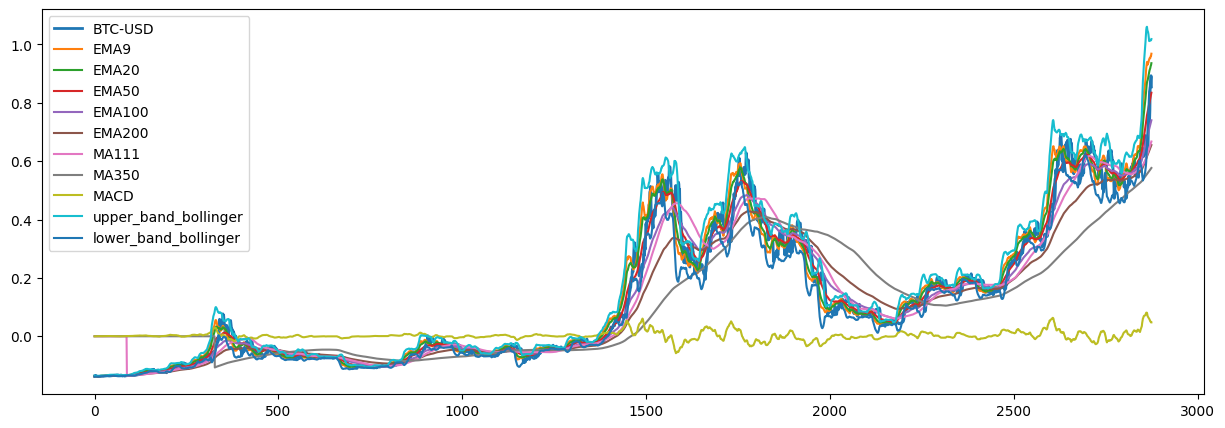

In [31]:
plt.figure(figsize=(15,5))
plt.plot(X[:,0],label=ticker,linewidth=2)
plt.plot(X[:,-len(features_indicators):])
plt.legend([ticker]+features_indicators)
plt.show()

In [32]:
# separa os dados em Treino e Teste
def split_data(X : np.array ,y : np.array, date_time : np.datetime64,factor=0.70):
    """Split the data in train validation or test

    Args:
        X (np.array): _description_
        y (np.array): _description_
        date_time (np.datetime64): _description_
        factor (float, optional): _description_. Defaults to 0.70.

    Returns:
        _type_: _description_
    """
    nits=round(len(X)*factor)

    X_train=X[:nits,:]

    nit_test= np.max(X_train.shape) -1
    X_test = X[nit_test:,:]

    y_train =y[:nits]
    y_test =y[nit_test:]

    T_train = date_time[:nits]
    T_test = date_time[nit_test:]
    
    return X_train,X_test, y_train, y_test, T_train, T_test

X_train,X_test, y_train, y_test, T_train, T_test=split_data(X,y,date_time, factor=0.85)

In [ ]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=T_train ,y=np.squeeze(y_train), mode='lines',name="Dados de Treino"))
fig.add_trace(go.Scatter(x=T_test, y=np.squeeze(y_test), mode='lines',name="Dados de Teste"))
# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title='HIstory Price',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)
fig.show()

## Neural Networkt aproach

### Used Models

#### CNN_LSTM

In [34]:
from tensorflow.keras.initializers import RandomUniform, glorot_uniform, he_uniform

model_name= "CNN_LSTM"
np.random.seed(42)
def CNN_LSTM(data_input):
    # define model architecture
    model = Sequential()
   
    model.add(Conv1D(64, kernel_size=5, strides=2, activation='relu',input_shape=(X.shape[1],1), kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    #model.add(GRU(64, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    
    model.add(Dropout(0.2))
    model.add(Flatten())
    return model

def dense_layers(features, n_outputs=1, name=None):
    model=features

    # layer 2
    model.add( tf.keras.layers.Dense(32, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation(tf.keras.activations.relu))

    # layer 3 - Output Layer 
    model.add(tf.keras.layers.Dense(n_outputs))
    model.add(tf.keras.layers.Activation(tf.keras.activations.linear))
    return model

features = CNN_LSTM(X)
model_CNN_LSTM=dense_layers(features, n_outputs = pred_days)
model_CNN_LSTM._name=model_name
model_CNN_LSTM.summary()



Model: "CNN_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 15, 64)            384       
                                                                 
 batch_normalization (Batch  (None, 15, 64)            256       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 7, 64)             0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 7, 64)             0         
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense (Dense)               (None, 32)                1

#### MultiLayer Perceptron

In [35]:
# Model name
model_name = "MLP"

# Input layer
input_data = Input(shape=(X.shape[1],))

# Dense layer 1 with batch normalization
dense1 = Dense(64)(input_data)
bn1 = BatchNormalization()(dense1)
activation1 = Activation('relu')(bn1)

# Dense layer 2 with batch normalization and dropout
dense2 = Dense(128)(activation1)
bn2 = BatchNormalization()(dense2)
activation2 = Activation('relu')(bn2)
dropout2 = Dropout(0.2)(activation2)

# Output layer
output = Dense(1, activation='linear')(dropout2)

# Create the model
model_MLP = Model(inputs=input_data, outputs=output)
model_MLP._name = model_name

# Print model summary
model_MLP.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense_2 (Dense)             (None, 64)                2176      
                                                                 
 batch_normalization_2 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                              

#### Long Short-Term Memory (LSTM) 

In [36]:
model_name= "LSTM"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
lstm_output  = LSTM(64, return_sequences=False)(input_data)
bn_lstm = BatchNormalization()(lstm_output)
activation_lstm = Activation('relu')(bn_lstm)
Dropout_output = Dropout(0.2)(activation_lstm)

#lstm_output2  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output2)

#lstm_output3  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output3)

#lstm_output  = LSTM(4, activation='tanh')(Dropout_output)
#Dropout_output = Dropout(0.2)(lstm_output)

#dense_output = Dense(32, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)

#dense_output = Dense(8, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)
# Camada de saída
output = Dense(1, activation='linear')(Dropout_output)

model_LSTM = Model(inputs=input_data, outputs=output)
model_LSTM._name = model_name
model_LSTM.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 33, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 batch_normalization_4 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 64)                0         
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                              

#### Long Short-Term Memory (GRU) 

In [37]:
model_name= "GRU"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
GRU_output  = GRU(64)(input_data)

bn_lstm = BatchNormalization()(GRU_output)
activation_lstm = Activation('relu')(bn_lstm)
Dropout_output = Dropout(0.2)(activation_lstm)

output = Dense(pred_days, activation='linear')(Dropout_output)

model_GRU = Model(inputs=input_data, outputs=output)
model_GRU._name = model_name
model_GRU.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 33, 1)]           0         
                                                                 
 gru (GRU)                   (None, 64)                12864     
                                                                 
 batch_normalization_5 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (None, 64)                0         
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                               

#### LSTM with Attention layer

In [38]:
# Define the Attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # Apply attention weights to input
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector

In [39]:
model_name= "LSTM_AT"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

LSTM_output = tf.keras.layers.LSTM(64, return_sequences=True)(input_data)

bn_lstm = BatchNormalization()(LSTM_output)
activation_lstm = Activation('relu')(bn_lstm)
X = Dropout(0.2)(activation_lstm)

x = Attention(64)(X)
x = tf.keras.layers.Dense(pred_days)(x)

model_LSTM_AT = tf.keras.Model(inputs=input_data, outputs=x)
model_LSTM_AT._name = model_name

model_LSTM_AT.summary()

Model: "LSTM_AT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 33, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 33, 64)            16896     
                                                                 
 batch_normalization_6 (Bat  (None, 33, 64)            256       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 33, 64)            0         
                                                                 
 dropout_4 (Dropout)         (None, 33, 64)            0         
                                                                 
 attention (Attention)       (None, 64)                4225      
                                                           

### Hyperparams and trainnig

**Metrics and Loss Functions**  

In [40]:
from tensorflow.keras import backend as K

def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot - K.epsilon()) )

def NRMSE(y_true, y_pred): # normalized_root_mean_squared_error
    return 1-K.sqrt(K.mean(K.square(y_pred - y_true))) 

MSE= tf.keras.losses.mean_squared_error
MAE = tf.keras.losses.mean_absolute_error
MAPE = tf.keras.losses.mean_absolute_percentage_error

**Optimizers**  

In [41]:
def get_optimizer():
    optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True, name="Adam")
    return optimizer1
    #optimizer2 = tf.keras.optimizers.RMSprop(learning_rate=0.05)

**Train options callbacks**  

In [42]:
# Avalia se está tendo avanção de desempenho no treinamento/validação e para caso não tenha avanço 
EarlyStopping=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=10, verbose=1, mode="min", restore_best_weights=True,)

# verifica se está tendo avanço de desempenho durante o treinamento, caso não reduz integralmente o lr
reduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 5, min_lr=1e-14,verbose=1)


checkpoint_filepath = './models_checkpoint/'
checkpoint_filepath =f'models/{model_name}_{ticker}_{lookback}_ex1'


def checkpoints(model_name):
    checkpoint_filepath =f'models/model_{model_name}_stock_{ticker}_lookback_{lookback}'
    csvLogger = tf.keras.callbacks.CSVLogger(checkpoint_filepath+'_history.csv', separator=',',append=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
    print("Training model :", checkpoint_filepath)

    return csvLogger, model_checkpoint_callback

### Models train

Training model : models/model_MLP_stock_BTC-USD_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: MLP
Epoch 1/200


53/54 [============================>.] - ETA: 0s - loss: 1.0340 - NRMSE: 0.3401
Epoch 1: val_loss improved from inf to 0.72875, saving model to models\model_MLP_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 14s 107ms/step - loss: 1.0266 - NRMSE: 0.3456 - val_loss: 0.7287 - val_NRMSE: 0.3196 - lr: 0.0500
Epoch 2/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0387 - NRMSE: 0.8197
Epoch 2: val_loss improved from 0.72875 to 0.01933, saving model to models\model_MLP_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 5s 98ms/step - loss: 0.0364 - NRMSE: 0.8244 - val_loss: 0.0193 - val_NRMSE: 0.8974 - lr: 0.0500
Epoch 3/200
40/54 [=====================>........] - ETA: 0s - loss: 0.0100 - NRMSE: 0.9053
Epoch 3: val_loss improved from 0.01933 to 0.00535, saving model to models\model_MLP_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 5s 86ms/step - loss: 0.0093 - NRMSE: 0.9097 - val_loss: 0.0053 - val_NRMSE: 0.9347 - lr: 0.0500
Epoch 4/200
45/54 [========================>.....] - ETA: 0s - loss: 0.0043 - NRMSE: 0.9375
Epoch 4: val_loss improved from 0.00535 to 0.00267, saving model to models\model_MLP_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 4s 77ms/step - loss: 0.0043 - NRMSE: 0.9368 - val_loss: 0.0027 - val_NRMSE: 0.9566 - lr: 0.0500
Epoch 5/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0035 - NRMSE: 0.9430
Epoch 5: val_loss improved from 0.00267 to 0.00219, saving model to models\model_MLP_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 4s 76ms/step - loss: 0.0035 - NRMSE: 0.9430 - val_loss: 0.0022 - val_NRMSE: 0.9665 - lr: 0.0500
Epoch 6/200
51/54 [===========================>..] - ETA: 0s - loss: 0.0047 - NRMSE: 0.9357
Epoch 6: val_loss did not improve from 0.00219
54/54 [==============================] - 1s 9ms/step - loss: 0.0047 - NRMSE: 0.9357 - val_loss: 0.0075 - val_NRMSE: 0.9449 - lr: 0.0500
Epoch 7/200
47/54 [=========================>....] - ETA: 0s - loss: 0.0033 - NRMSE: 0.9456
Epoch 7: val_loss did not improve from 0.00219
54/54 [==============================] - 1s 12ms/step - loss: 0.0033 - NRMSE: 0.9461 - val_loss: 0.0097 - val_NRMSE: 0.9281 - lr: 0.0500
Epoch 8/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0037 - NRMSE: 0.9438
Epoch 8: val_loss did not improve from 0.00219
54/54 [==============================] - 1s 11ms/step - loss: 0.0037 - NRMSE: 0.9442 - val_loss: 0.0082 - val_NRMSE: 0.9412 - lr: 0.0500
Epoch 9/200
44/54 [=================

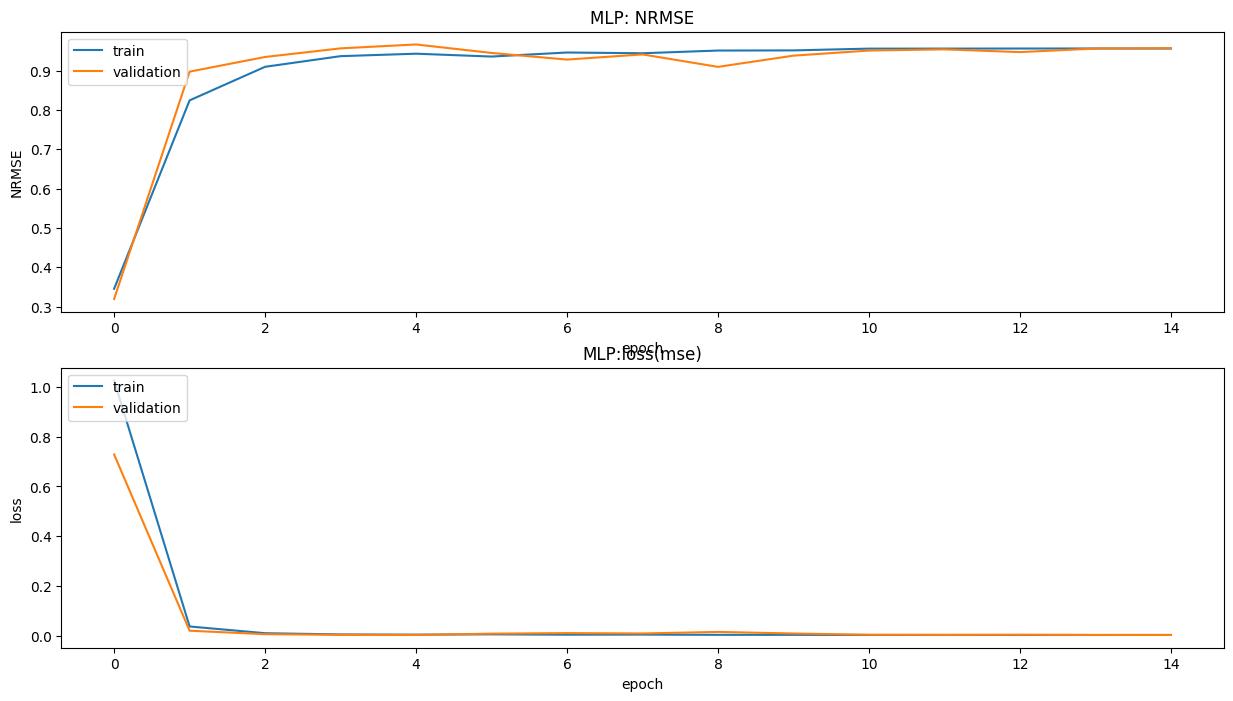

Training model : models/model_GRU_stock_BTC-USD_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: GRU
Epoch 1/200
53/54 [============================>.] - ETA: 0s - loss: 0.0983 - NRMSE: 0.8227
Epoch 1: val_loss improved from inf to 0.03408, saving model to models\model_GRU_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 31s 256ms/step - loss: 0.0975 - NRMSE: 0.8252 - val_loss: 0.0341 - val_NRMSE: 0.8637 - lr: 0.0500
Epoch 2/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0049 - NRMSE: 0.9340
Epoch 2: val_loss improved from 0.03408 to 0.02384, saving model to models\model_GRU_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 12s 229ms/step - loss: 0.0048 - NRMSE: 0.9346 - val_loss: 0.0238 - val_NRMSE: 0.8906 - lr: 0.0500
Epoch 3/200
54/54 [==============================] - ETA: 0s - loss: 0.0036 - NRMSE: 0.9428
Epoch 3: val_loss improved from 0.02384 to 0.01635, saving model to models\model_GRU_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 10s 194ms/step - loss: 0.0036 - NRMSE: 0.9428 - val_loss: 0.0164 - val_NRMSE: 0.8977 - lr: 0.0500
Epoch 4/200
54/54 [==============================] - ETA: 0s - loss: 0.0044 - NRMSE: 0.9362
Epoch 4: val_loss improved from 0.01635 to 0.01484, saving model to models\model_GRU_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 8s 151ms/step - loss: 0.0044 - NRMSE: 0.9362 - val_loss: 0.0148 - val_NRMSE: 0.8976 - lr: 0.0500
Epoch 5/200
53/54 [============================>.] - ETA: 0s - loss: 0.0035 - NRMSE: 0.9440
Epoch 5: val_loss did not improve from 0.01484
54/54 [==============================] - 2s 37ms/step - loss: 0.0035 - NRMSE: 0.9440 - val_loss: 0.0151 - val_NRMSE: 0.9053 - lr: 0.0500
Epoch 6/200
53/54 [============================>.] - ETA: 0s - loss: 0.0045 - NRMSE: 0.9370
Epoch 6: val_loss improved from 0.01484 to 0.01261, saving model to models\model_GRU_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 9s 170ms/step - loss: 0.0045 - NRMSE: 0.9377 - val_loss: 0.0126 - val_NRMSE: 0.8996 - lr: 0.0500
Epoch 7/200
54/54 [==============================] - ETA: 0s - loss: 0.0047 - NRMSE: 0.9360
Epoch 7: val_loss improved from 0.01261 to 0.00972, saving model to models\model_GRU_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 8s 146ms/step - loss: 0.0047 - NRMSE: 0.9360 - val_loss: 0.0097 - val_NRMSE: 0.9172 - lr: 0.0500
Epoch 8/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0045 - NRMSE: 0.9362
Epoch 8: val_loss did not improve from 0.00972
54/54 [==============================] - 1s 26ms/step - loss: 0.0044 - NRMSE: 0.9371 - val_loss: 0.0234 - val_NRMSE: 0.8771 - lr: 0.0500
Epoch 9/200
53/54 [============================>.] - ETA: 0s - loss: 0.0037 - NRMSE: 0.9422
Epoch 9: val_loss improved from 0.00972 to 0.00602, saving model to models\model_GRU_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 7s 132ms/step - loss: 0.0037 - NRMSE: 0.9419 - val_loss: 0.0060 - val_NRMSE: 0.9336 - lr: 0.0500
Epoch 10/200
51/54 [===========================>..] - ETA: 0s - loss: 0.0037 - NRMSE: 0.9418
Epoch 10: val_loss did not improve from 0.00602
54/54 [==============================] - 1s 22ms/step - loss: 0.0036 - NRMSE: 0.9421 - val_loss: 0.0122 - val_NRMSE: 0.8965 - lr: 0.0500
Epoch 11/200
53/54 [============================>.] - ETA: 0s - loss: 0.0032 - NRMSE: 0.9456
Epoch 11: val_loss did not improve from 0.00602
54/54 [==============================] - 2s 29ms/step - loss: 0.0032 - NRMSE: 0.9455 - val_loss: 2.1639 - val_NRMSE: -0.4599 - lr: 0.0500
Epoch 12/200
54/54 [==============================] - ETA: 0s - loss: 0.0036 - NRMSE: 0.9423
Epoch 12: val_loss did not improve from 0.00602
54/54 [==============================] - 1s 25ms/step - loss: 0.0036 - NRMSE: 0.9423 - val_loss: 0.6132 - val_NRMSE: 0.2174 - lr: 0.0500
Epoch 13/200
54/54 [=======

INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 8s 152ms/step - loss: 0.0040 - NRMSE: 0.9396 - val_loss: 0.0057 - val_NRMSE: 0.9291 - lr: 0.0100
Epoch 16/200
53/54 [============================>.] - ETA: 0s - loss: 0.0024 - NRMSE: 0.9523
Epoch 16: val_loss did not improve from 0.00566
54/54 [==============================] - 1s 27ms/step - loss: 0.0024 - NRMSE: 0.9524 - val_loss: 0.0059 - val_NRMSE: 0.9248 - lr: 0.0100
Epoch 17/200
53/54 [============================>.] - ETA: 0s - loss: 0.0031 - NRMSE: 0.9465
Epoch 17: val_loss did not improve from 0.00566
54/54 [==============================] - 2s 30ms/step - loss: 0.0031 - NRMSE: 0.9461 - val_loss: 0.0235 - val_NRMSE: 0.8484 - lr: 0.0100
Epoch 18/200
53/54 [============================>.] - ETA: 0s - loss: 0.0029 - NRMSE: 0.9490
Epoch 18: val_loss improved from 0.00566 to 0.00544, saving model to models\model_GRU_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 7s 140ms/step - loss: 0.0029 - NRMSE: 0.9488 - val_loss: 0.0054 - val_NRMSE: 0.9273 - lr: 0.0100
Epoch 19/200
51/54 [===========================>..] - ETA: 0s - loss: 0.0028 - NRMSE: 0.9488
Epoch 19: val_loss did not improve from 0.00544
54/54 [==============================] - 1s 24ms/step - loss: 0.0028 - NRMSE: 0.9490 - val_loss: 0.0109 - val_NRMSE: 0.8992 - lr: 0.0100
Epoch 20/200
53/54 [============================>.] - ETA: 0s - loss: 0.0027 - NRMSE: 0.9503
Epoch 20: val_loss did not improve from 0.00544
54/54 [==============================] - 1s 25ms/step - loss: 0.0027 - NRMSE: 0.9505 - val_loss: 0.0114 - val_NRMSE: 0.8961 - lr: 0.0100
Epoch 21/200
54/54 [==============================] - ETA: 0s - loss: 0.0031 - NRMSE: 0.9481
Epoch 21: val_loss improved from 0.00544 to 0.00360, saving model to models\model_GRU_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 7s 128ms/step - loss: 0.0031 - NRMSE: 0.9481 - val_loss: 0.0036 - val_NRMSE: 0.9446 - lr: 0.0100
Epoch 22/200
53/54 [============================>.] - ETA: 0s - loss: 0.0027 - NRMSE: 0.9508
Epoch 22: val_loss did not improve from 0.00360
54/54 [==============================] - 1s 28ms/step - loss: 0.0027 - NRMSE: 0.9509 - val_loss: 0.0094 - val_NRMSE: 0.9055 - lr: 0.0100
Epoch 23/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0030 - NRMSE: 0.9494
Epoch 23: val_loss did not improve from 0.00360
54/54 [==============================] - 1s 26ms/step - loss: 0.0030 - NRMSE: 0.9493 - val_loss: 0.0426 - val_NRMSE: 0.7951 - lr: 0.0100
Epoch 24/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0027 - NRMSE: 0.9503
Epoch 24: val_loss did not improve from 0.00360
54/54 [==============================] - 1s 23ms/step - loss: 0.0028 - NRMSE: 0.9498 - val_loss: 0.0386 - val_NRMSE: 0.8052 - lr: 0.0100
Epoch 25/200
51/54 [========

INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 7s 139ms/step - loss: 0.0026 - NRMSE: 0.9523 - val_loss: 8.7336e-04 - val_NRMSE: 0.9724 - lr: 0.0020
Epoch 28/200
53/54 [============================>.] - ETA: 0s - loss: 0.0023 - NRMSE: 0.9539
Epoch 28: val_loss improved from 0.00087 to 0.00077, saving model to models\model_GRU_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 8s 144ms/step - loss: 0.0023 - NRMSE: 0.9541 - val_loss: 7.6778e-04 - val_NRMSE: 0.9748 - lr: 0.0020
Epoch 29/200
53/54 [============================>.] - ETA: 0s - loss: 0.0025 - NRMSE: 0.9522
Epoch 29: val_loss improved from 0.00077 to 0.00070, saving model to models\model_GRU_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 6s 121ms/step - loss: 0.0024 - NRMSE: 0.9523 - val_loss: 7.0220e-04 - val_NRMSE: 0.9762 - lr: 0.0020
Epoch 30/200
53/54 [============================>.] - ETA: 0s - loss: 0.0026 - NRMSE: 0.9519
Epoch 30: val_loss did not improve from 0.00070
54/54 [==============================] - 1s 27ms/step - loss: 0.0026 - NRMSE: 0.9516 - val_loss: 9.0277e-04 - val_NRMSE: 0.9739 - lr: 0.0020
Epoch 31/200
54/54 [==============================] - ETA: 0s - loss: 0.0024 - NRMSE: 0.9531
Epoch 31: val_loss did not improve from 0.00070
54/54 [==============================] - 1s 24ms/step - loss: 0.0024 - NRMSE: 0.9531 - val_loss: 0.0048 - val_NRMSE: 0.9320 - lr: 0.0020
Epoch 32/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0022 - NRMSE: 0.9552
Epoch 32: val_loss did not improve from 0.00070
54/54 [==============================] - 1s 24ms/step - loss: 0.0022 - NRMSE: 0.9548 - val_loss: 7.2625e-04 - val_NRMSE: 0.9763 - lr: 0.0020
Epoch 33/200
54/

INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 7s 138ms/step - loss: 0.0025 - NRMSE: 0.9531 - val_loss: 6.7799e-04 - val_NRMSE: 0.9770 - lr: 4.0000e-04
Epoch 39/200
51/54 [===========================>..] - ETA: 0s - loss: 0.0023 - NRMSE: 0.9549
Epoch 39: val_loss did not improve from 0.00068
54/54 [==============================] - 2s 42ms/step - loss: 0.0023 - NRMSE: 0.9546 - val_loss: 6.9895e-04 - val_NRMSE: 0.9773 - lr: 8.0000e-05
Epoch 40/200
54/54 [==============================] - ETA: 0s - loss: 0.0023 - NRMSE: 0.9541
Epoch 40: val_loss did not improve from 0.00068
54/54 [==============================] - 2s 40ms/step - loss: 0.0023 - NRMSE: 0.9541 - val_loss: 7.8140e-04 - val_NRMSE: 0.9765 - lr: 8.0000e-05
Epoch 41/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0025 - NRMSE: 0.9530
Epoch 41: val_loss did not improve from 0.00068
54/54 [==============================] - 2s 46ms/step - loss: 0.0025 - NRMSE: 0.9529 - val_loss: 7.5261e-04 - val_NRMSE: 0.9769 - lr: 8.0000e

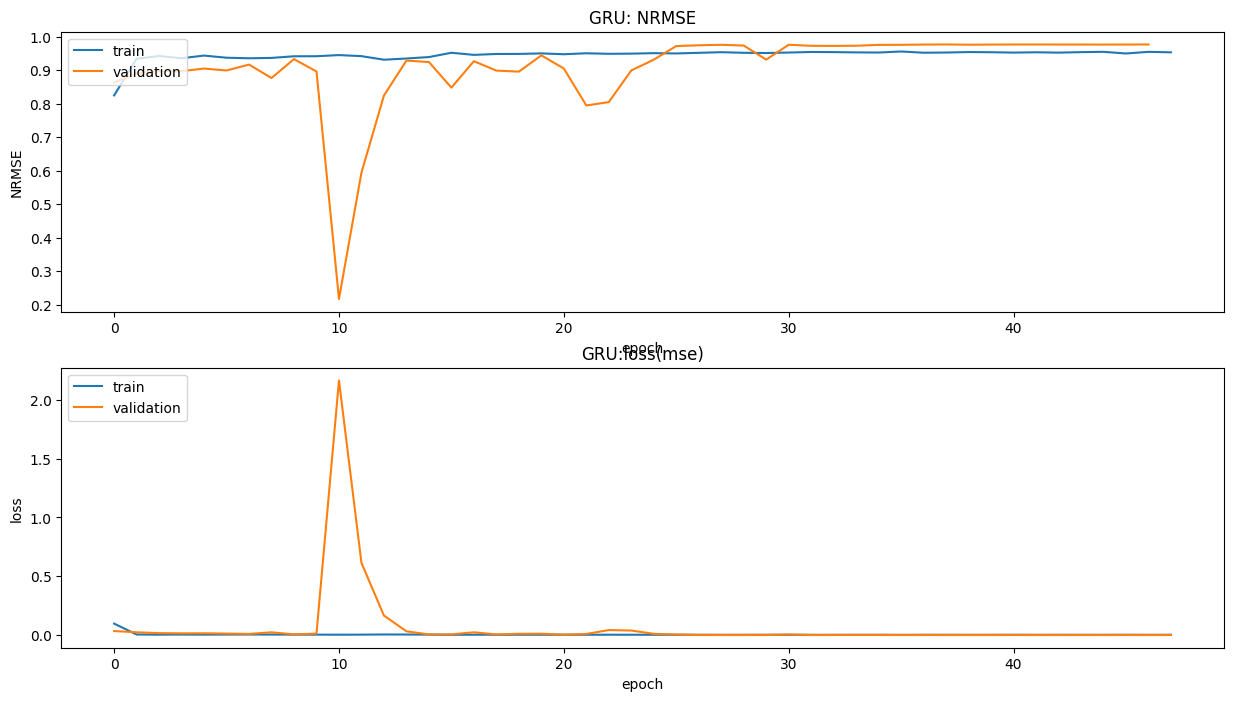

Training model : models/model_CNN_LSTM_stock_BTC-USD_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: CNN_LSTM
Epoch 1/200
54/54 [==============================] - ETA: 0s - loss: 0.2328 - NRMSE: 0.7189
Epoch 1: val_loss improved from inf to 0.00355, saving model to models\model_CNN_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 8s 75ms/step - loss: 0.2328 - NRMSE: 0.7189 - val_loss: 0.0035 - val_NRMSE: 0.9539 - lr: 0.0500
Epoch 2/200
54/54 [==============================] - ETA: 0s - loss: 0.0039 - NRMSE: 0.9427
Epoch 2: val_loss did not improve from 0.00355
54/54 [==============================] - 1s 11ms/step - loss: 0.0039 - NRMSE: 0.9427 - val_loss: 0.0061 - val_NRMSE: 0.9397 - lr: 0.0500
Epoch 3/200
47/54 [=========================>....] - ETA: 0s - loss: 0.0032 - NRMSE: 0.9488
Epoch 3: val_loss did not improve from 0.00355
54/54 [==============================] - 1s 11ms/step - loss: 0.0033 - NRMSE: 0.9479 - val_loss: 0.0076 - val_NRMSE: 0.9358 - lr: 0.0500
Epoch 4/200
50/54 [==========================>...] - ETA: 0s - loss: 0.0033 - NRMSE: 0.9469
Epoch 4: val_loss did not improve from 0.00355
54/54 [==============================] - 1s 10ms/step - loss: 0.0032 - NRMSE: 0.9469 - val_loss: 0.0061 - val_NRMSE: 0.9406 - lr: 0.0500
Epoch 5/200
48/54 [================

INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 3s 61ms/step - loss: 0.0025 - NRMSE: 0.9547 - val_loss: 0.0030 - val_NRMSE: 0.9606 - lr: 0.0500
Epoch 6/200
47/54 [=========================>....] - ETA: 0s - loss: 0.0022 - NRMSE: 0.9573
Epoch 6: val_loss did not improve from 0.00303
54/54 [==============================] - 0s 9ms/step - loss: 0.0020 - NRMSE: 0.9583 - val_loss: 0.0050 - val_NRMSE: 0.9431 - lr: 0.0500
Epoch 7/200
45/54 [========================>.....] - ETA: 0s - loss: 0.0021 - NRMSE: 0.9579
Epoch 7: val_loss did not improve from 0.00303
54/54 [==============================] - 0s 9ms/step - loss: 0.0022 - NRMSE: 0.9564 - val_loss: 0.0063 - val_NRMSE: 0.9304 - lr: 0.0500
Epoch 8/200
53/54 [============================>.] - ETA: 0s - loss: 0.0025 - NRMSE: 0.9532
Epoch 8: val_loss did not improve from 0.00303
54/54 [==============================] - 1s 9ms/step - loss: 0.0025 - NRMSE: 0.9529 - val_loss: 0.0037 - val_NRMSE: 0.9553 - lr: 0.0500
Epoch 9/200
46/54 [===================

INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 3s 57ms/step - loss: 0.0020 - NRMSE: 0.9582 - val_loss: 0.0021 - val_NRMSE: 0.9643 - lr: 0.0500
Epoch 10/200
46/54 [========================>.....] - ETA: 0s - loss: 0.0021 - NRMSE: 0.9569
Epoch 10: val_loss improved from 0.00214 to 0.00176, saving model to models\model_CNN_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 3s 58ms/step - loss: 0.0021 - NRMSE: 0.9573 - val_loss: 0.0018 - val_NRMSE: 0.9667 - lr: 0.0500
Epoch 11/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0019 - NRMSE: 0.9590
Epoch 11: val_loss did not improve from 0.00176
54/54 [==============================] - 0s 9ms/step - loss: 0.0019 - NRMSE: 0.9593 - val_loss: 0.0023 - val_NRMSE: 0.9585 - lr: 0.0500
Epoch 12/200
47/54 [=========================>....] - ETA: 0s - loss: 0.0016 - NRMSE: 0.9628
Epoch 12: val_loss did not improve from 0.00176
54/54 [==============================] - 0s 9ms/step - loss: 0.0016 - NRMSE: 0.9626 - val_loss: 0.0019 - val_NRMSE: 0.9626 - lr: 0.0500
Epoch 13/200
51/54 [===========================>..] - ETA: 0s - loss: 0.0017 - NRMSE: 0.9610
Epoch 13: val_loss did not improve from 0.00176
54/54 [==============================] - 1s 11ms/step - loss: 0.0017 - NRMSE: 0.9615 - val_loss: 0.0028 - val_NRMSE: 0.9515 - lr: 0.0500
Epoch 14/200
48/54 [===========

INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 3s 60ms/step - loss: 0.0021 - NRMSE: 0.9557 - val_loss: 0.0017 - val_NRMSE: 0.9671 - lr: 0.0500
Epoch 15/200
53/54 [============================>.] - ETA: 0s - loss: 0.0014 - NRMSE: 0.9648
Epoch 15: val_loss improved from 0.00170 to 0.00152, saving model to models\model_CNN_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 4s 77ms/step - loss: 0.0014 - NRMSE: 0.9645 - val_loss: 0.0015 - val_NRMSE: 0.9672 - lr: 0.0500
Epoch 16/200
49/54 [==========================>...] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9678
Epoch 16: val_loss improved from 0.00152 to 0.00136, saving model to models\model_CNN_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 3s 60ms/step - loss: 0.0011 - NRMSE: 0.9677 - val_loss: 0.0014 - val_NRMSE: 0.9666 - lr: 0.0500
Epoch 17/200
50/54 [==========================>...] - ETA: 0s - loss: 0.0013 - NRMSE: 0.9649
Epoch 17: val_loss did not improve from 0.00136
54/54 [==============================] - 1s 13ms/step - loss: 0.0014 - NRMSE: 0.9635 - val_loss: 0.0027 - val_NRMSE: 0.9593 - lr: 0.0500
Epoch 18/200
48/54 [=========================>....] - ETA: 0s - loss: 0.0017 - NRMSE: 0.9629
Epoch 18: val_loss did not improve from 0.00136
54/54 [==============================] - 1s 14ms/step - loss: 0.0017 - NRMSE: 0.9632 - val_loss: 0.0028 - val_NRMSE: 0.9517 - lr: 0.0500
Epoch 19/200
48/54 [=========================>....] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9689
Epoch 19: val_loss did not improve from 0.00136
54/54 [==============================] - 1s 10ms/step - loss: 0.0010 - NRMSE: 0.9698 - val_loss: 0.0020 - val_NRMSE: 0.9595 - lr: 0.0500
Epoch 20/200
53/54 [=========

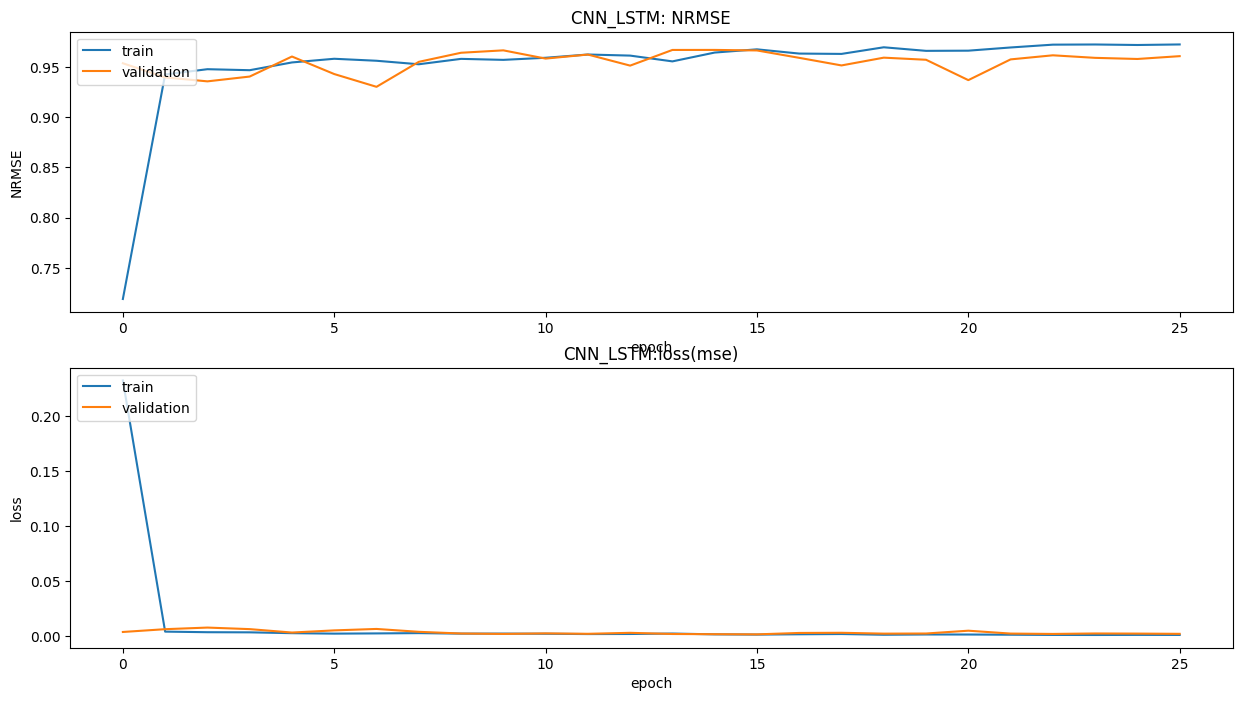

Training model : models/model_LSTM_stock_BTC-USD_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: LSTM
Epoch 1/200
54/54 [==============================] - ETA: 0s - loss: 0.2147 - NRMSE: 0.7915
Epoch 1: val_loss improved from inf to 0.10238, saving model to models\model_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 14s 193ms/step - loss: 0.2147 - NRMSE: 0.7915 - val_loss: 0.1024 - val_NRMSE: 0.7095 - lr: 0.0500
Epoch 2/200
51/54 [===========================>..] - ETA: 0s - loss: 0.0044 - NRMSE: 0.9359
Epoch 2: val_loss did not improve from 0.10238
54/54 [==============================] - 3s 53ms/step - loss: 0.0043 - NRMSE: 0.9377 - val_loss: 0.1028 - val_NRMSE: 0.7091 - lr: 0.0500
Epoch 3/200
51/54 [===========================>..] - ETA: 0s - loss: 0.0043 - NRMSE: 0.9379
Epoch 3: val_loss improved from 0.10238 to 0.06384, saving model to models\model_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 8s 144ms/step - loss: 0.0044 - NRMSE: 0.9368 - val_loss: 0.0638 - val_NRMSE: 0.7830 - lr: 0.0500
Epoch 4/200
54/54 [==============================] - ETA: 0s - loss: 0.0066 - NRMSE: 0.9230
Epoch 4: val_loss improved from 0.06384 to 0.05869, saving model to models\model_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 7s 132ms/step - loss: 0.0066 - NRMSE: 0.9230 - val_loss: 0.0587 - val_NRMSE: 0.7955 - lr: 0.0500
Epoch 5/200
53/54 [============================>.] - ETA: 0s - loss: 0.0037 - NRMSE: 0.9413
Epoch 5: val_loss improved from 0.05869 to 0.03412, saving model to models\model_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 9s 165ms/step - loss: 0.0037 - NRMSE: 0.9406 - val_loss: 0.0341 - val_NRMSE: 0.8587 - lr: 0.0500
Epoch 6/200
54/54 [==============================] - ETA: 0s - loss: 0.0046 - NRMSE: 0.9370
Epoch 6: val_loss did not improve from 0.03412
54/54 [==============================] - 1s 23ms/step - loss: 0.0046 - NRMSE: 0.9370 - val_loss: 0.0393 - val_NRMSE: 0.8379 - lr: 0.0500
Epoch 7/200
53/54 [============================>.] - ETA: 0s - loss: 0.0034 - NRMSE: 0.9438
Epoch 7: val_loss did not improve from 0.03412
54/54 [==============================] - 2s 46ms/step - loss: 0.0034 - NRMSE: 0.9440 - val_loss: 0.0569 - val_NRMSE: 0.7942 - lr: 0.0500
Epoch 8/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0030 - NRMSE: 0.9476
Epoch 8: val_loss improved from 0.03412 to 0.01379, saving model to models\model_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 8s 159ms/step - loss: 0.0030 - NRMSE: 0.9475 - val_loss: 0.0138 - val_NRMSE: 0.9166 - lr: 0.0500
Epoch 9/200
53/54 [============================>.] - ETA: 0s - loss: 0.0034 - NRMSE: 0.9443
Epoch 9: val_loss did not improve from 0.01379
54/54 [==============================] - 1s 23ms/step - loss: 0.0034 - NRMSE: 0.9448 - val_loss: 0.0374 - val_NRMSE: 0.8373 - lr: 0.0500
Epoch 10/200
51/54 [===========================>..] - ETA: 0s - loss: 0.0036 - NRMSE: 0.9434
Epoch 10: val_loss did not improve from 0.01379
54/54 [==============================] - 3s 49ms/step - loss: 0.0036 - NRMSE: 0.9434 - val_loss: 0.0268 - val_NRMSE: 0.8666 - lr: 0.0500
Epoch 11/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0038 - NRMSE: 0.9409
Epoch 11: val_loss improved from 0.01379 to 0.01097, saving model to models\model_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 8s 145ms/step - loss: 0.0037 - NRMSE: 0.9415 - val_loss: 0.0110 - val_NRMSE: 0.9029 - lr: 0.0500
Epoch 12/200
54/54 [==============================] - ETA: 0s - loss: 0.0032 - NRMSE: 0.9453
Epoch 12: val_loss did not improve from 0.01097
54/54 [==============================] - 2s 31ms/step - loss: 0.0032 - NRMSE: 0.9453 - val_loss: 0.0123 - val_NRMSE: 0.9109 - lr: 0.0500
Epoch 13/200
54/54 [==============================] - ETA: 0s - loss: 0.0043 - NRMSE: 0.9386
Epoch 13: val_loss did not improve from 0.01097
54/54 [==============================] - 1s 23ms/step - loss: 0.0043 - NRMSE: 0.9386 - val_loss: 1.4048 - val_NRMSE: -0.1849 - lr: 0.0500
Epoch 14/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0047 - NRMSE: 0.9347
Epoch 14: val_loss did not improve from 0.01097
54/54 [==============================] - 2s 30ms/step - loss: 0.0047 - NRMSE: 0.9355 - val_loss: 0.3561 - val_NRMSE: 0.4041 - lr: 0.0500
Epoch 15/200
52/54 [=======

INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 8s 146ms/step - loss: 0.0025 - NRMSE: 0.9523 - val_loss: 0.0012 - val_NRMSE: 0.9697 - lr: 0.0100
Epoch 19/200
53/54 [============================>.] - ETA: 0s - loss: 0.0029 - NRMSE: 0.9488
Epoch 19: val_loss did not improve from 0.00118
54/54 [==============================] - 1s 27ms/step - loss: 0.0029 - NRMSE: 0.9491 - val_loss: 0.0074 - val_NRMSE: 0.9164 - lr: 0.0100
Epoch 20/200
53/54 [============================>.] - ETA: 0s - loss: 0.0023 - NRMSE: 0.9542
Epoch 20: val_loss did not improve from 0.00118
54/54 [==============================] - 1s 23ms/step - loss: 0.0022 - NRMSE: 0.9548 - val_loss: 0.0034 - val_NRMSE: 0.9459 - lr: 0.0100
Epoch 21/200
54/54 [==============================] - ETA: 0s - loss: 0.0027 - NRMSE: 0.9506
Epoch 21: val_loss did not improve from 0.00118
54/54 [==============================] - 2s 33ms/step - loss: 0.0027 - NRMSE: 0.9506 - val_loss: 0.0013 - val_NRMSE: 0.9683 - lr: 0.0100
Epoch 22/200
54/54 [========

INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 8s 154ms/step - loss: 0.0027 - NRMSE: 0.9500 - val_loss: 0.0011 - val_NRMSE: 0.9696 - lr: 0.0100
Epoch 24/200
53/54 [============================>.] - ETA: 0s - loss: 0.0026 - NRMSE: 0.9506
Epoch 24: val_loss improved from 0.00115 to 0.00108, saving model to models\model_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 7s 130ms/step - loss: 0.0026 - NRMSE: 0.9506 - val_loss: 0.0011 - val_NRMSE: 0.9713 - lr: 0.0020
Epoch 25/200
54/54 [==============================] - ETA: 0s - loss: 0.0024 - NRMSE: 0.9539
Epoch 25: val_loss did not improve from 0.00108
54/54 [==============================] - 1s 23ms/step - loss: 0.0024 - NRMSE: 0.9539 - val_loss: 0.0014 - val_NRMSE: 0.9654 - lr: 0.0020
Epoch 26/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0027 - NRMSE: 0.9507
Epoch 26: val_loss did not improve from 0.00108
54/54 [==============================] - 1s 24ms/step - loss: 0.0027 - NRMSE: 0.9510 - val_loss: 0.0014 - val_NRMSE: 0.9658 - lr: 0.0020
Epoch 27/200
54/54 [==============================] - ETA: 0s - loss: 0.0023 - NRMSE: 0.9535
Epoch 27: val_loss did not improve from 0.00108
54/54 [==============================] - 2s 39ms/step - loss: 0.0023 - NRMSE: 0.9535 - val_loss: 0.0015 - val_NRMSE: 0.9652 - lr: 0.0020
Epoch 28/200
54/54 [========

INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 8s 142ms/step - loss: 0.0023 - NRMSE: 0.9530 - val_loss: 9.6765e-04 - val_NRMSE: 0.9728 - lr: 0.0020
Epoch 29/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0027 - NRMSE: 0.9507
Epoch 29: val_loss did not improve from 0.00097
54/54 [==============================] - 2s 35ms/step - loss: 0.0026 - NRMSE: 0.9511 - val_loss: 0.0013 - val_NRMSE: 0.9662 - lr: 0.0020
Epoch 30/200
54/54 [==============================] - ETA: 0s - loss: 0.0027 - NRMSE: 0.9505
Epoch 30: val_loss improved from 0.00097 to 0.00089, saving model to models\model_LSTM_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 8s 142ms/step - loss: 0.0027 - NRMSE: 0.9505 - val_loss: 8.8507e-04 - val_NRMSE: 0.9742 - lr: 0.0020
Epoch 31/200
51/54 [===========================>..] - ETA: 0s - loss: 0.0025 - NRMSE: 0.9535
Epoch 31: val_loss did not improve from 0.00089
54/54 [==============================] - 1s 23ms/step - loss: 0.0025 - NRMSE: 0.9529 - val_loss: 9.7218e-04 - val_NRMSE: 0.9722 - lr: 0.0020
Epoch 32/200
51/54 [===========================>..] - ETA: 0s - loss: 0.0024 - NRMSE: 0.9527
Epoch 32: val_loss did not improve from 0.00089
54/54 [==============================] - 2s 32ms/step - loss: 0.0025 - NRMSE: 0.9517 - val_loss: 0.0010 - val_NRMSE: 0.9721 - lr: 0.0020
Epoch 33/200
53/54 [============================>.] - ETA: 0s - loss: 0.0024 - NRMSE: 0.9529
Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.

Epoch 33: val_loss did not improve from 0.00089
54/54 [==============================] - 1s 21ms/step - loss: 0.0024 - NRMSE: 0

INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 8s 154ms/step - loss: 0.0028 - NRMSE: 0.9503 - val_loss: 8.6585e-04 - val_NRMSE: 0.9746 - lr: 4.0000e-04
Epoch 35/200
54/54 [==============================] - ETA: 0s - loss: 0.0026 - NRMSE: 0.9522
Epoch 35: val_loss did not improve from 0.00087
54/54 [==============================] - 2s 35ms/step - loss: 0.0026 - NRMSE: 0.9522 - val_loss: 8.7552e-04 - val_NRMSE: 0.9742 - lr: 4.0000e-04
Epoch 36/200
51/54 [===========================>..] - ETA: 0s - loss: 0.0025 - NRMSE: 0.9532
Epoch 36: val_loss did not improve from 0.00087
54/54 [==============================] - 1s 23ms/step - loss: 0.0024 - NRMSE: 0.9537 - val_loss: 8.8346e-04 - val_NRMSE: 0.9741 - lr: 4.0000e-04
Epoch 37/200
53/54 [============================>.] - ETA: 0s - loss: 0.0023 - NRMSE: 0.9533
Epoch 37: val_loss did not improve from 0.00087
54/54 [==============================] - 1s 21ms/step - loss: 0.0023 - NRMSE: 0.9531 - val_loss: 8.9159e-04 - val_NRMSE: 0.9738 - lr: 4.0000e

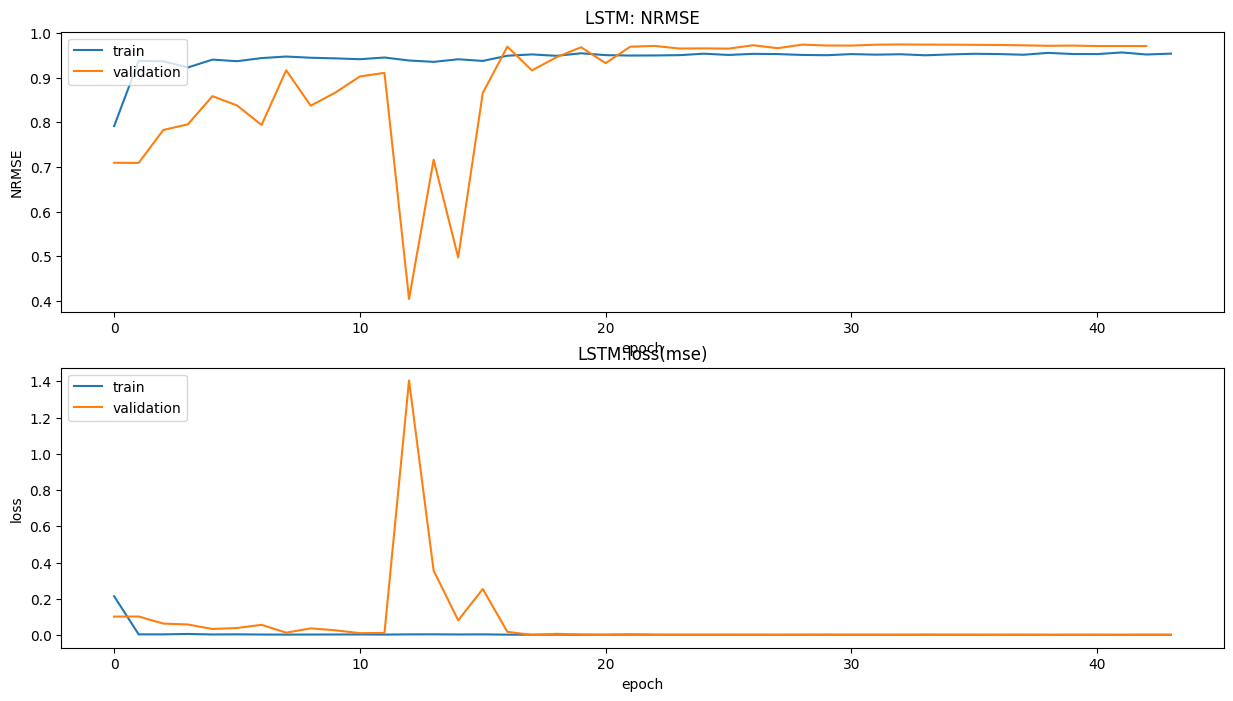

Training model : models/model_LSTM_AT_stock_BTC-USD_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: LSTM_AT
Epoch 1/200
54/54 [==============================] - ETA: 0s - loss: 0.1388 - NRMSE: 0.7743
Epoch 1: val_loss improved from inf to 0.03024, saving model to models\model_LSTM_AT_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 16s 168ms/step - loss: 0.1388 - NRMSE: 0.7743 - val_loss: 0.0302 - val_NRMSE: 0.8748 - lr: 0.0500
Epoch 2/200
53/54 [============================>.] - ETA: 0s - loss: 0.0032 - NRMSE: 0.9469
Epoch 2: val_loss improved from 0.03024 to 0.01223, saving model to models\model_LSTM_AT_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 8s 151ms/step - loss: 0.0031 - NRMSE: 0.9474 - val_loss: 0.0122 - val_NRMSE: 0.9167 - lr: 0.0500
Epoch 3/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0025 - NRMSE: 0.9523
Epoch 3: val_loss did not improve from 0.01223
54/54 [==============================] - 2s 46ms/step - loss: 0.0025 - NRMSE: 0.9522 - val_loss: 0.0242 - val_NRMSE: 0.8790 - lr: 0.0500
Epoch 4/200
53/54 [============================>.] - ETA: 0s - loss: 0.0019 - NRMSE: 0.9581
Epoch 4: val_loss did not improve from 0.01223
54/54 [==============================] - 2s 39ms/step - loss: 0.0019 - NRMSE: 0.9580 - val_loss: 0.0149 - val_NRMSE: 0.9126 - lr: 0.0500
Epoch 5/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0032 - NRMSE: 0.9478
Epoch 5: val_loss improved from 0.01223 to 0.01221, saving model to models\model_LSTM_AT_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 7s 136ms/step - loss: 0.0032 - NRMSE: 0.9481 - val_loss: 0.0122 - val_NRMSE: 0.8999 - lr: 0.0500
Epoch 6/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0024 - NRMSE: 0.9533
Epoch 6: val_loss did not improve from 0.01221
54/54 [==============================] - 2s 30ms/step - loss: 0.0025 - NRMSE: 0.9523 - val_loss: 0.0126 - val_NRMSE: 0.9134 - lr: 0.0500
Epoch 7/200
54/54 [==============================] - ETA: 0s - loss: 0.0019 - NRMSE: 0.9579
Epoch 7: val_loss improved from 0.01221 to 0.00860, saving model to models\model_LSTM_AT_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 8s 154ms/step - loss: 0.0019 - NRMSE: 0.9579 - val_loss: 0.0086 - val_NRMSE: 0.9167 - lr: 0.0500
Epoch 8/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0015 - NRMSE: 0.9628
Epoch 8: val_loss improved from 0.00860 to 0.00443, saving model to models\model_LSTM_AT_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 7s 132ms/step - loss: 0.0015 - NRMSE: 0.9630 - val_loss: 0.0044 - val_NRMSE: 0.9496 - lr: 0.0500
Epoch 9/200
54/54 [==============================] - ETA: 0s - loss: 0.0017 - NRMSE: 0.9616
Epoch 9: val_loss improved from 0.00443 to 0.00301, saving model to models\model_LSTM_AT_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 8s 148ms/step - loss: 0.0017 - NRMSE: 0.9616 - val_loss: 0.0030 - val_NRMSE: 0.9606 - lr: 0.0500
Epoch 10/200
54/54 [==============================] - ETA: 0s - loss: 0.0022 - NRMSE: 0.9563
Epoch 10: val_loss did not improve from 0.00301
54/54 [==============================] - 2s 30ms/step - loss: 0.0022 - NRMSE: 0.9563 - val_loss: 0.0077 - val_NRMSE: 0.9149 - lr: 0.0500
Epoch 11/200
54/54 [==============================] - ETA: 0s - loss: 0.0016 - NRMSE: 0.9616
Epoch 11: val_loss improved from 0.00301 to 0.00224, saving model to models\model_LSTM_AT_stock_BTC-USD_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_BTC-USD_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_BTC-USD_lookback_23\assets


54/54 [==============================] - 9s 161ms/step - loss: 0.0016 - NRMSE: 0.9616 - val_loss: 0.0022 - val_NRMSE: 0.9574 - lr: 0.0500
Epoch 12/200
53/54 [============================>.] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9677
Epoch 12: val_loss did not improve from 0.00224
54/54 [==============================] - 2s 31ms/step - loss: 0.0011 - NRMSE: 0.9677 - val_loss: 0.0091 - val_NRMSE: 0.9081 - lr: 0.0500
Epoch 13/200
52/54 [===========================>..] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9687
Epoch 13: val_loss did not improve from 0.00224
54/54 [==============================] - 2s 33ms/step - loss: 0.0011 - NRMSE: 0.9684 - val_loss: 0.0063 - val_NRMSE: 0.9236 - lr: 0.0500
Epoch 14/200
53/54 [============================>.] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9659
Epoch 14: val_loss did not improve from 0.00224
54/54 [==============================] - 2s 30ms/step - loss: 0.0012 - NRMSE: 0.9656 - val_loss: 0.0090 - val_NRMSE: 0.9086 - lr: 0.0500
Epoch 15/200
52/54 [========

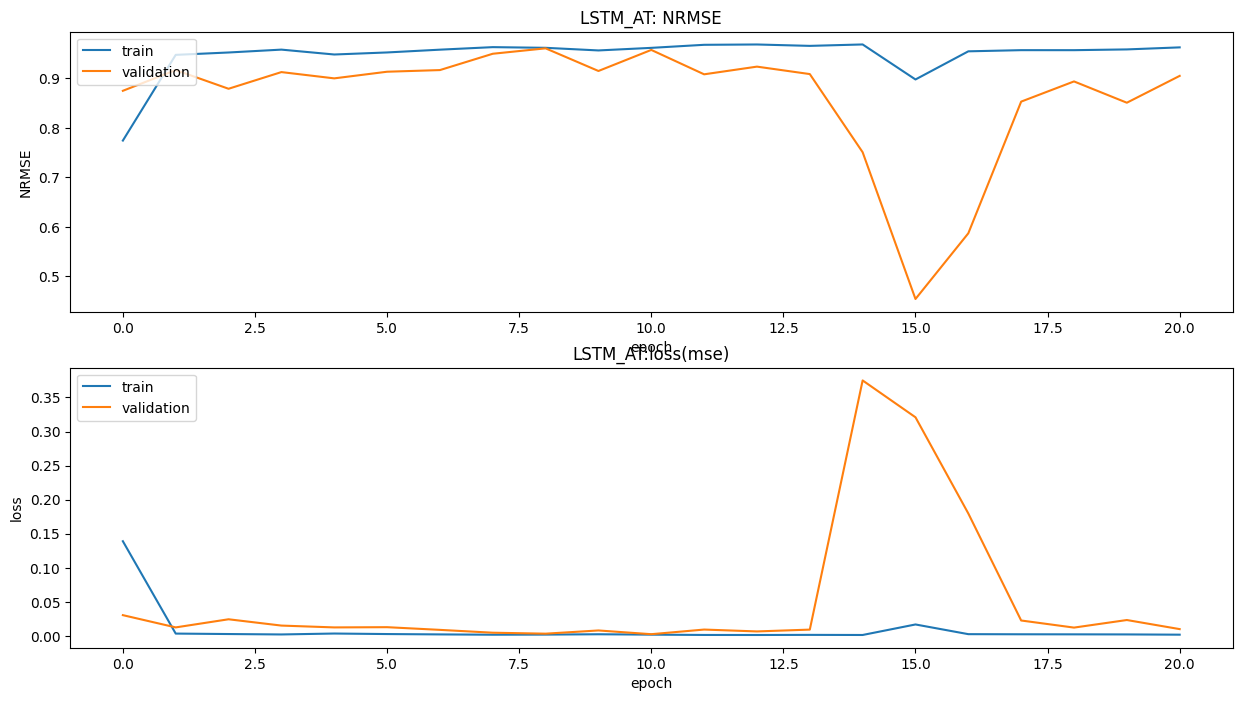

In [43]:
list_of_models=[model_MLP, model_GRU, model_CNN_LSTM, model_LSTM, model_LSTM_AT]
#list_of_models=[model_LSTM, model_LSTM_AT, model_GRU ]

for model in list_of_models:  
    optimizer = get_optimizer()
    csvLogger, model_checkpoint_callback  = checkpoints(model._name)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[NRMSE])

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(f'Initing train fo model: {model._name}')
    history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=32, shuffle=True, validation_split=0.3 ,callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback,csvLogger])

    history_metric=np.array(history.history['NRMSE']) 
    history_metric_val=np.array(history.history['val_NRMSE'])  

    plt.figure(1,figsize=(15,8))  
    # summarize history for accuracy  
    plt.subplot(211)  
    plt.plot(history_metric[history_metric>0]) 
    plt.plot(history_metric_val[history_metric_val>0])  
    plt.title(f'{model._name}: NRMSE')  
    plt.ylabel('NRMSE')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left') 
    # summarize history for loss  
    plt.subplot(212)  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])   
    plt.title(f'{model._name}:loss(mse)')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show()  
    #history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=256, shuffle=True, validation_split=0.1, callbacks=[EarlyStopping,model_checkpoint_callback, reduceLr])

### Validation

In [44]:
# carrega os modelos terinados
from tensorflow import keras
trained_best_models={}
for model in list_of_models:
    checkpoint_filepath =f'models/model_{model._name}_stock_{ticker}_lookback_{lookback}'
    trained_best_models[f'{model._name}']=keras.models.load_model(checkpoint_filepath, custom_objects={'NRMSE':NRMSE})

In [45]:
checkpoint_filepath

'models/model_LSTM_AT_stock_BTC-USD_lookback_23'

In [46]:
trained_best_models

{'MLP': <keras.src.engine.functional.Functional at 0x1f63bb51330>,
 'GRU': <keras.src.engine.functional.Functional at 0x1f63bb51660>,
 'CNN_LSTM': <keras.src.engine.sequential.Sequential at 0x1f6396c8dc0>,
 'LSTM': <keras.src.engine.functional.Functional at 0x1f6217e3d90>,
 'LSTM_AT': <keras.src.engine.functional.Functional at 0x1f63fdcf8b0>}

In [47]:
def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  np.sum(np.square( y_true-y_pred ))
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot) )

X_real, y_real = windowing(df,features_indicators)

for idx in range(len(features_indicators)+lookback):
    X_real[:,idx]=np.squeeze(scaler.transform(X_real[:,idx].reshape(-1,1)))
#X_real=features_scaler.transform(X_real)
#y_real=scaler.transform(y_real)
#X_real=features_scaler(X_real)

#do the smae split data with the original data to compare 
X_train_real,X_test_real, y_train_real, y_test_real,T_train,_=split_data(X_real,y_real,date_time, factor=0.85)

predictions=[]
for model_name in trained_best_models:
    y_pred=scaler.inverse_transform(trained_best_models[model_name].predict(X_test))
    r2_score= R2(y_test_real, y_pred )
    print(model_name,'NN R2:', r2_score)

    predictions+=[y_pred]
predictions=np.hstack(predictions)

14/14 [==============================] - 0s 2ms/step
MLP NN R2: 0.19174933278637496
14/14 [==============================] - 1s 9ms/step
GRU NN R2: 0.8984504959699875
14/14 [==============================] - 0s 3ms/step
CNN_LSTM NN R2: 0.8171561023662621
14/14 [==============================] - 1s 7ms/step
LSTM NN R2: 0.9038003018656107
14/14 [==============================] - 1s 8ms/step
LSTM_AT NN R2: -3.7025175817013842


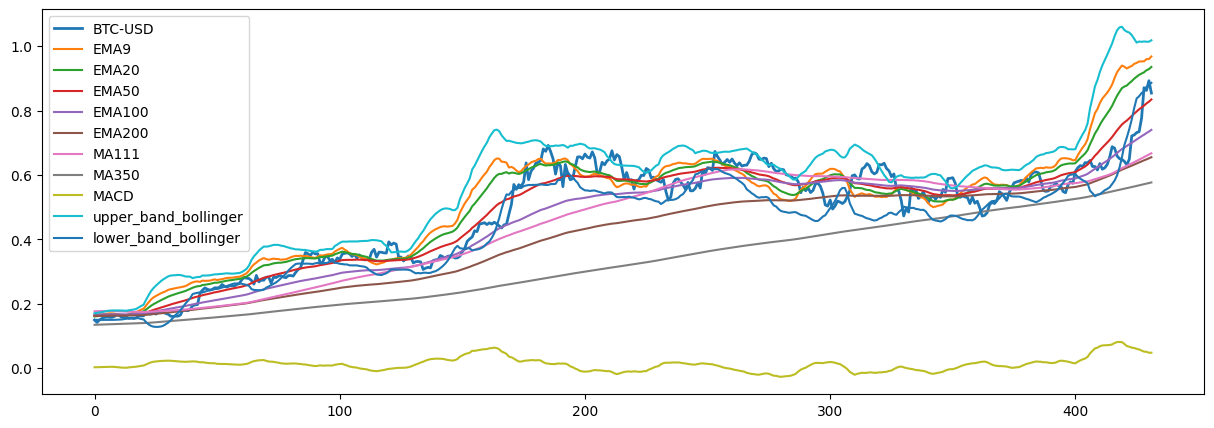

In [48]:
plt.figure(figsize=(15,5))
plt.plot(X_test[:,0],label=ticker,linewidth=2)
plt.plot(X_test[:,-len(features_indicators):])
plt.legend([ticker]+features_indicators)
plt.show()

In [49]:
y_test_real=np.hstack(y_test_real)
y_pred=np.hstack(y_pred)
y_train_real=np.hstack(y_train_real)

In [50]:
trained_best_models.keys()

dict_keys(['MLP', 'GRU', 'CNN_LSTM', 'LSTM', 'LSTM_AT'])

In [51]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

# Adiciona os valores reais ao gráfico
#fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name='Real', line=dict(color='red')))
fig.add_trace(go.Scatter(x=T_train, y=y_train_real, mode='lines',name="Dados de Treino",line=dict(color='black')))
fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name="Dados de Teste", line=dict(color='red')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'yellow', 'violet', 'yellowgreen', 'green']
for i in range(predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_test, y=predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))

# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()


### Get new values to future prediction 

In [52]:
dias_antes=1
n_steps=7

print("Temos dados até o dia :",T_test.iloc[-1].date())

print("Estamos Fornecendo dados até o dia :",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes))

print("O modelo fará previsões até o dia: ",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes) + datetime.timedelta(days=n_steps))

Temos dados até o dia : 2024-12-07
Estamos Fornecendo dados até o dia : 2024-12-06
O modelo fará previsões até o dia:  2024-12-13


In [53]:
new_predictions=[]
for model in list_of_models:
    # processo interativo para predição com o modelo de rede neural
    dias_antes=1
    n_steps=5

    if dias_antes == 0:
        NN_predictions=y_test.copy()
        # normalized data
        X_inputs=comput_features(scaler.transform(y_test_real.reshape(-1,1)),lookback, features_indicators).reshape(1,-1)
        #X_inputs=X_test.copy()
        
        T_preds=T_test.values.copy()
    else :
        NN_predictions=y_test[:-dias_antes].copy()
    
        X_inputs=comput_features(scaler.transform(y_test_real.reshape(-1,1))[:-dias_antes,:],lookback, features_indicators).reshape(1,-1)

        #X_inputs=X_test[:-dias_antes,:].copy()
        T_preds=T_test.values[:-dias_antes].copy()
    continuous_time=T_preds.copy()
    
    for k in range(n_steps):
        # normalzação das features
        #for idx in range(len(features_indicators)+lookback):
        #    X_inputs[-1,idx]=np.squeeze(scaler.transform(X_inputs[-1,idx].reshape(-1,1)))
        

        # realizar a predição interativa com o modelo
        y_pred=model.predict(X_inputs[-1,:].reshape(1,-1))

        # guarda a predição do modelo para usa-la como entrada para a proxima predição
        NN_predictions=np.append(NN_predictions,[y_pred[0][0]])
        X_inputs=np.append(X_inputs,comput_features(NN_predictions,lookback, features_indicators).reshape(1,-1),axis=0)

        
        #X_inputs=np.append(X_inputs,NN_predictions[-lookback:].reshape(1,-1),axis=0)

        # acrescenta um dia ao tempo atual 
        next_day=continuous_time[-1]+np.timedelta64(1,'D')
        continuous_time=np.append(continuous_time,next_day)    
        # verifica se o próximo dia é final de semana, se for pula até o dia útil 
        while next_day.astype('datetime64[D]').astype(datetime.datetime).isoweekday() > 5:
            # acrescenta um dia ao tempo atual 
            next_day=continuous_time[-1]+np.timedelta64(1,'D')
            continuous_time=np.append(continuous_time,next_day)

        T_preds=np.append(T_preds,next_day)
        
    new_predictions+=[scaler.inverse_transform(NN_predictions.reshape(-1,1))]
new_predictions=np.hstack(new_predictions)

1/1 [==============================] - 0s 33ms/step


In [54]:
# ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

combined_data_train=np.append(y_train,y_test[:-dias_antes])

try:
    if model_arima_fit is not None:
        print('Using ARIMA model')
except:
    model_arima = ARIMA(combined_data_train, order=(30, 2, 7))
    model_arima_fit = model_arima.fit()

    arima_predictions = model_arima_fit.predict(start=len(combined_data_train), end=len(combined_data_train)+n_steps)
    arima_predictions=np.hstack(scaler.inverse_transform(arima_predictions.reshape(-1,1)))
    arima_predictions.shape

d:\Projetos_python\Time_Series_Forecast\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

d:\Projetos_python\Time_Series_Forecast\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

d:\Projetos_python\Time_Series_Forecast\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [55]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=T_preds[-(n_steps+1):], y=arima_predictions, mode='lines', name="Predicted ARIMA", line=dict(color='green')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'tomato', 'violet', 'yellowgreen', 'green']
for i in range(new_predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_preds, y=new_predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))


# Adiciona os valores reais ao gráfico
fig.add_trace(go.Scatter(x=T_test.values, y=y_test_real, mode='lines', name=ticker, line=dict(color='black')))
# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()

In [56]:
# modelos treinados 
[model.name for model in list_of_models]

['MLP', 'GRU', 'CNN_LSTM', 'LSTM', 'LSTM_AT']

In [57]:
model_idx=[model.name for model in list_of_models].index('CNN_LSTM')

pred_data_df=pd.DataFrame({'Data': T_preds, 'pred': new_predictions[:,model_idx]})
# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100

# Definir a variável alvo com base na variação percentual
pred_data_df['Subida'] = pred_data_df['Variacao'].apply(lambda x: 1 if x > 0.02 else 0)
pred_data_df.tail(10)

Data          pred   Variacao  Subida
426 2024-12-02  95865.304688  -1.475491       0
427 2024-12-03  96002.164062   0.142559       1
428 2024-12-04  98768.531250   2.800859       1
429 2024-12-05  96593.570312  -2.251662       0
430 2024-12-06  99920.710938   3.329781       1
431 2024-12-09  88445.698370 -12.974076       0
432 2024-12-10  84683.219693  -4.443004       0
433 2024-12-11  85539.980288   1.001591       1
434 2024-12-12  82265.606224  -3.980247       0
435 2024-12-13  80558.569076  -2.119001       0

In [58]:
pred_data_df[pred_data_df['Data']==df['Date'].iloc[-1]]

Empty DataFrame
Columns: [Data, pred, Variacao, Subida]
Index: []

In [59]:
result=pred_data_df.iloc[-1:,:]
result

Data          pred  Variacao  Subida
435 2024-12-13  80558.569076 -2.119001       0

In [60]:
print("A previsão para o dia", result['Data'].item().date(),
      "é de", 'subida,' if result['Subida'].values==1 else "Descida,",
      f"de {np.round(result['Variacao'].values[0],2)}%",
      "o valor predito é de:", np.round(result['pred'].values[0],2) )

A previsão para o dia 2024-12-13 é de Descida, de -2.12% o valor predito é de: 80558.57


In [61]:
comput_features(y_test, lookback, features_indicators).reshape(1,-1)

array([[0.89833514, 0.89250794, 0.88432598, 0.89232613, 0.91300592,
        0.93591948, 0.9837424 , 0.98940204, 0.97539028, 0.97810609,
        0.92171469, 0.90889018, 0.95455432, 0.95099435, 0.97176492,
        0.96014031, 0.96967835, 0.95343802, 0.95500936, 0.98677126,
        0.96179956, 0.99999996, 0.997241  , 0.97402236, 0.94154446,
        0.84088198, 0.74523546, 0.66526167, 0.67161436, 0.57850773,
        0.04691857, 1.01865072, 0.89733815]])

In [62]:
model_idx=[model.name for model in list_of_models].index('CNN_LSTM')
model=list_of_models[model_idx]
X_features=comput_features(y_test, lookback, features_indicators).reshape(1,-1)
scaler.inverse_transform(model.predict(X_features))

1/1 [==============================] - 0s 95ms/step


array([[87759.44]], dtype=float32)